In [177]:
%matplotlib inline

import os
import tarfile
import urllib
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error


DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"


def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)


# fetch_housing_data()

df = load_housing_data()

# Initial Analysis

In [178]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


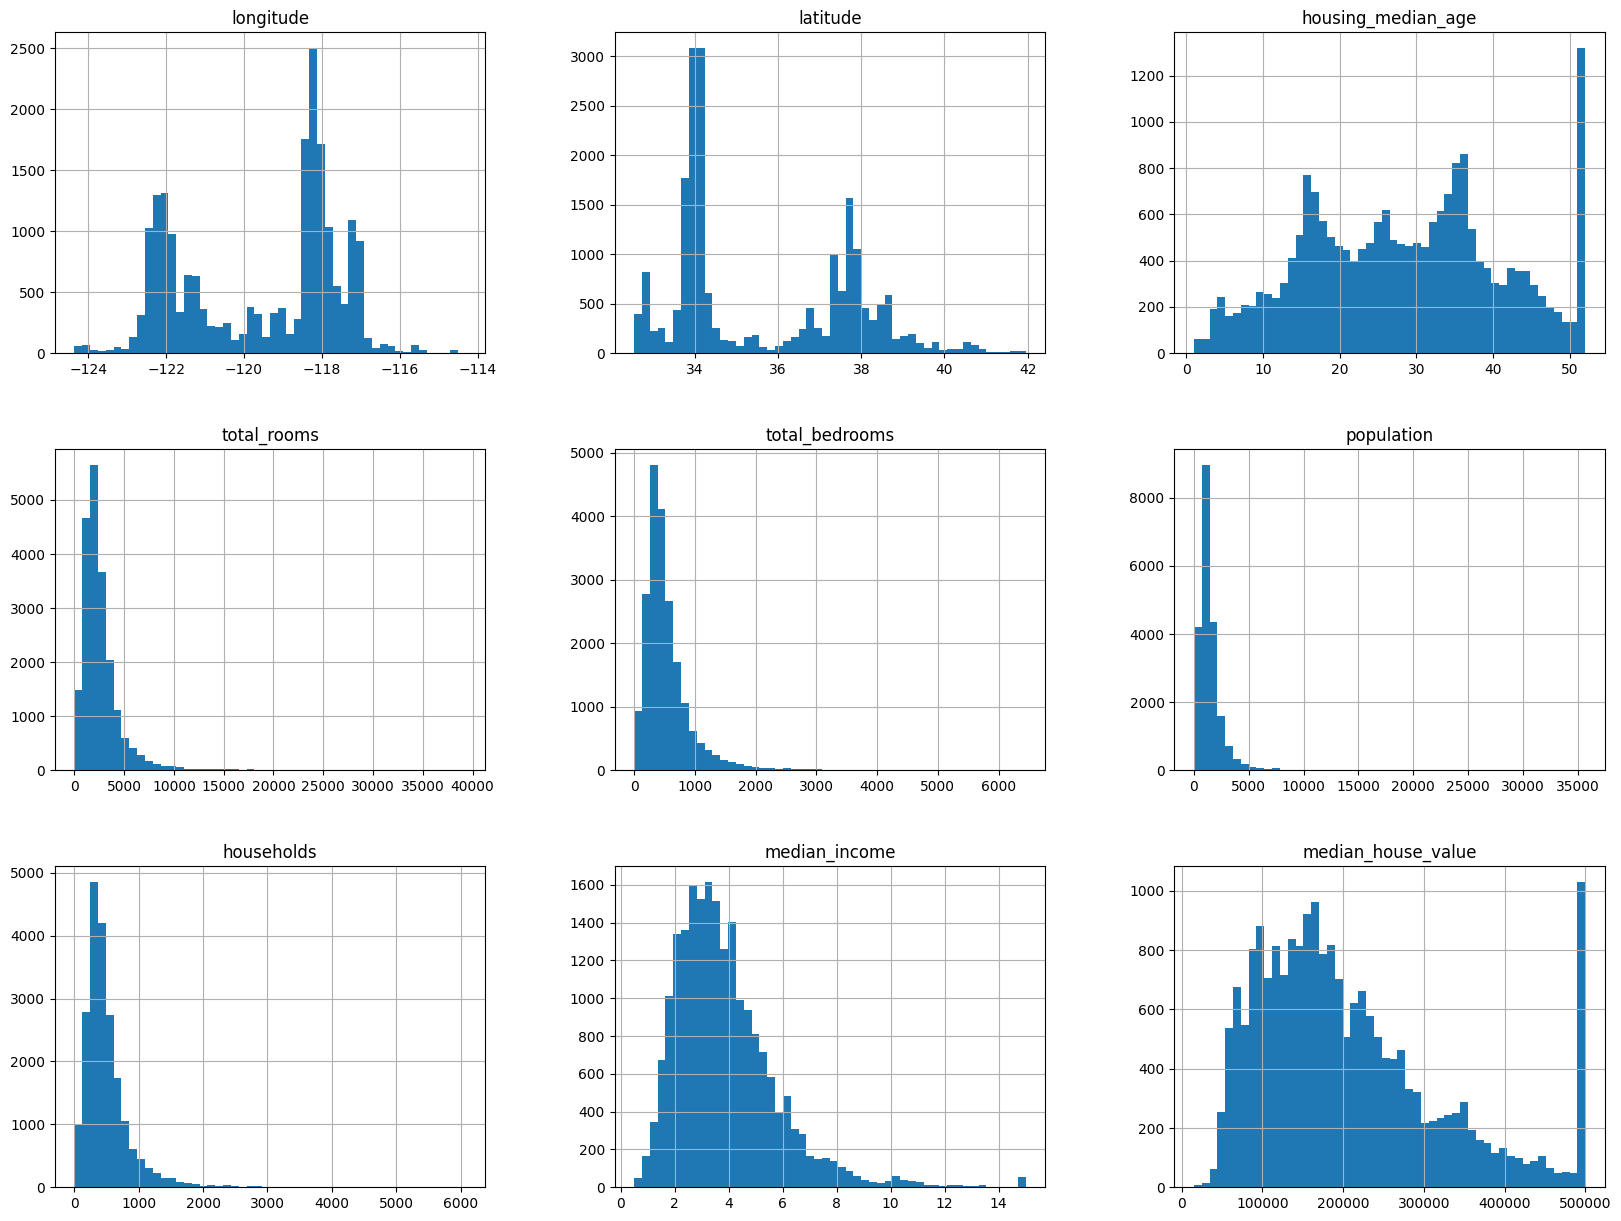

In [179]:
df.hist(bins=50, figsize=(20,15))
plt.show()

# Correlation Analysis

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

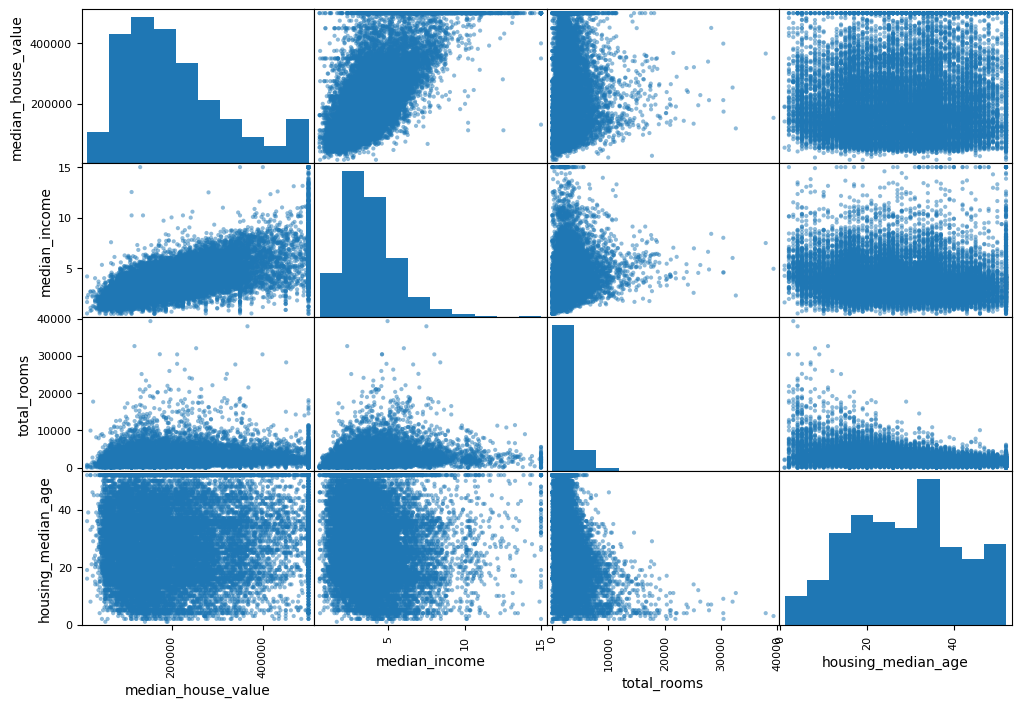

In [180]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(df[attributes], figsize=(12, 8))

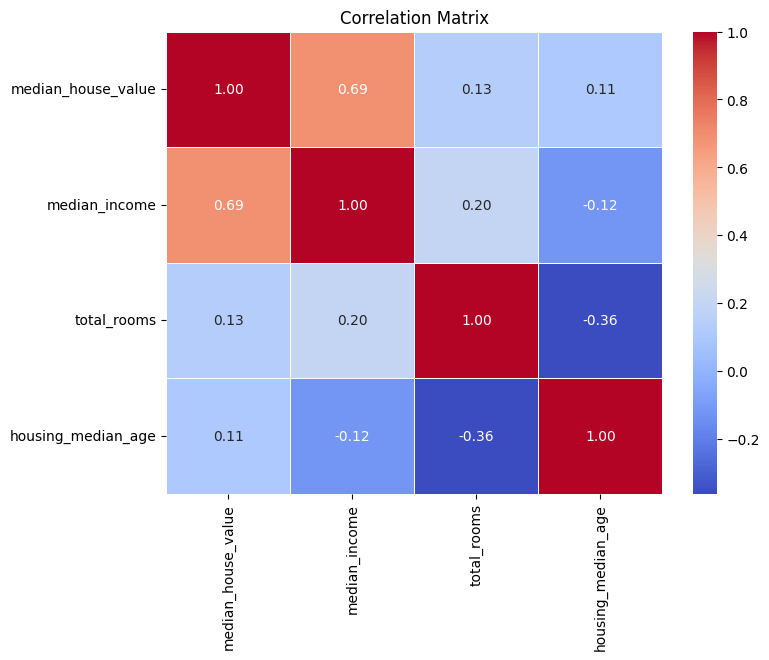

In [181]:
plt.figure(figsize=(8, 6)) # Adjust figure size as needed
sns.heatmap(df[attributes].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64


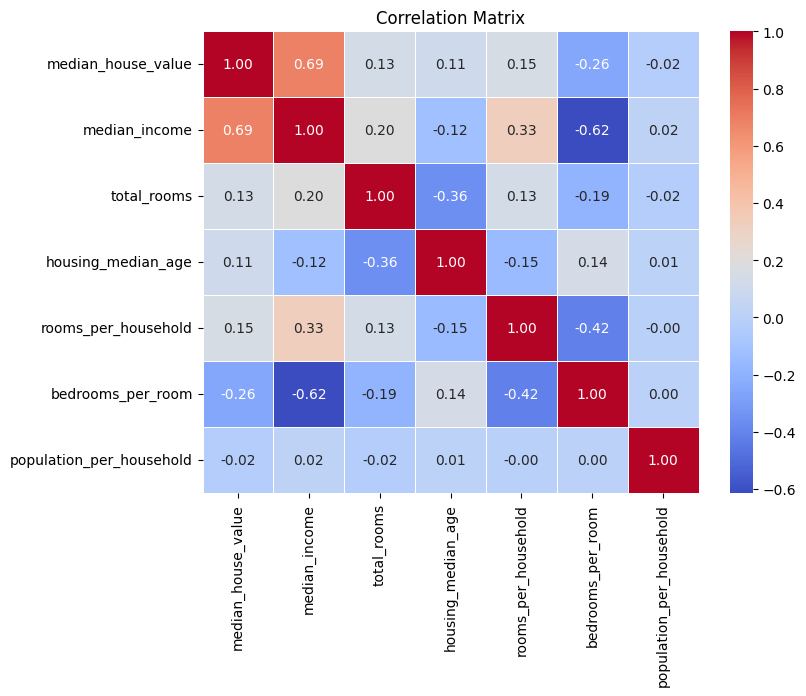

In [182]:
df["rooms_per_household"] = df["total_rooms"]/df["households"]
df["bedrooms_per_room"] = df["total_bedrooms"]/df["total_rooms"]
df["population_per_household"] = df["population"]/df["households"]

corr_matrix = df.drop('ocean_proximity', axis=1).corr()
print(corr_matrix["median_house_value"].sort_values(ascending=False))

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age", "rooms_per_household", "bedrooms_per_room", "population_per_household"]
plt.figure(figsize=(8, 6)) # Adjust figure size as needed
sns.heatmap(df[attributes].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [183]:
# Dropping so it can be added by custom pipeline function
df = df.drop(["rooms_per_household", "bedrooms_per_room", "population_per_household"], axis=1)

# Stratified Split

<Axes: >

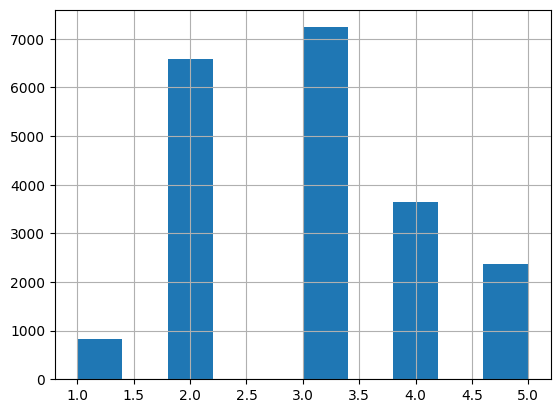

In [184]:
df["income_cat"] = pd.cut(df["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

df["income_cat"].hist()

In [185]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["income_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

print(strat_test_set["income_cat"].value_counts() / len(strat_test_set))

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

df = strat_train_set.copy()

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64


In [186]:
df = strat_train_set.drop("median_house_value", axis=1)
df_labels = strat_train_set["median_house_value"].copy()

# Processing Pipeline

In [187]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN


In [188]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 12655 to 19773
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


In [189]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000
mean,-119.575635,35.639314,28.653404,2622.539789,534.914639,1419.687379,497.011810,3.875884
std,2.001828,2.137963,12.574819,2138.417080,412.665649,1115.663036,375.696156,1.904931
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566950
50%,-118.510000,34.260000,29.000000,2119.000000,433.000000,1164.000000,408.000000,3.541550
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.000000,602.000000,4.745325
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100


In [190]:
# imputer = SimpleImputer(strategy="median")
# df_num = df.drop("ocean_proximity", axis=1)
# imputer.fit(df_num)

# X = imputer.transform(df_num)
# df_tr = pd.DataFrame(X, columns=df_num.columns, index=df_num.index)
# df_tr.info()

In [191]:
# df_cat = df[["ocean_proximity"]]

# cat_encoder = OneHotEncoder()

# df_cat_1hot = cat_encoder.fit_transform(df_cat)
# df_cat_1hot

In [192]:
# df_cat_1hot.toarray()

In [193]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6


class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]


attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
df_extra_attribs = attr_adder.transform(df.values)

df_extra_attribs

array([[-121.46, 38.52, 29.0, ..., 'INLAND', 5.485835694050992,
        3.168555240793201],
       [-117.23, 33.09, 7.0, ..., 'NEAR OCEAN', 6.927083333333333,
        2.6236979166666665],
       [-119.04, 35.37, 44.0, ..., 'INLAND', 5.3933333333333335,
        2.223333333333333],
       ...,
       [-122.72, 38.44, 48.0, ..., '<1H OCEAN', 4.1104651162790695,
        2.6627906976744184],
       [-122.7, 38.31, 14.0, ..., '<1H OCEAN', 6.297405189620759,
        2.411177644710579],
       [-122.14, 39.97, 27.0, ..., 'INLAND', 5.477157360406092,
        3.1725888324873095]], dtype=object)

In [194]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

num_attribs = list(df_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

df_prepared = full_pipeline.fit_transform(df)
df_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

# First Version of Linear Model

Root Mean Squared Error: 68627.87390018745


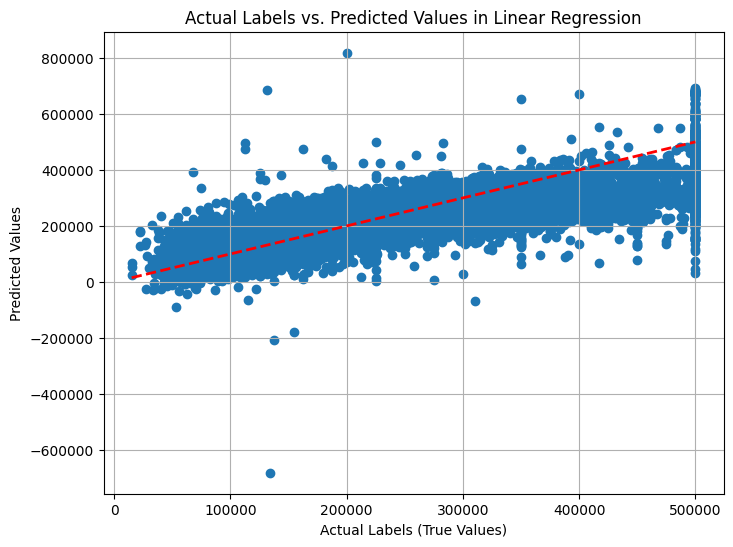

In [195]:
from sklearn.linear_model import LinearRegression


lin_reg = LinearRegression()
lin_reg.fit(df_prepared, df_labels)

# some_data = full_pipeline.transform(df.iloc[:5])
# some_labels = df_labels.iloc[:5]
# predictions = lin_reg.predict(some_data)

# predict_dict = {}
# for i in range(len(some_data)):
#     predict_dict[some_labels.iloc[i]] = predictions[i]

# print("Prediction dict:", predict_dict)

y_test = df_labels
y_pred = lin_reg.predict(df_prepared)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Root Mean Squared Error:", rmse)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=1) # Plot actual labels vs predicted values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Add a perfect prediction line (red dashed)
plt.xlabel("Actual Labels (True Values)")
plt.ylabel("Predicted Values")
plt.title("Actual Labels vs. Predicted Values in Linear Regression")
plt.grid(True)
plt.show()

In [196]:
np.argmin(y_pred)

3438

In [197]:
df.iloc[3438]

longitude               -117.42
latitude                  33.35
housing_median_age         14.0
total_rooms             25135.0
total_bedrooms           4819.0
population              35682.0
households               4769.0
median_income            2.5729
ocean_proximity       <1H OCEAN
Name: 15360, dtype: object

In [198]:
some_data = full_pipeline.transform(df.iloc[3438:3439])
some_labels = df_labels.iloc[3438:3439]
predictions = lin_reg.predict(some_data)

predict_dict = {}
for i in range(len(some_data)):
    predict_dict[some_labels.iloc[i]] = predictions[i]

display(df.iloc[3438:3439])
print("Prediction dict:", predict_dict)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
15360,-117.42,33.35,14.0,25135.0,4819.0,35682.0,4769.0,2.5729,<1H OCEAN


Prediction dict: {134400.0: -681332.2798958711}


<Axes: >

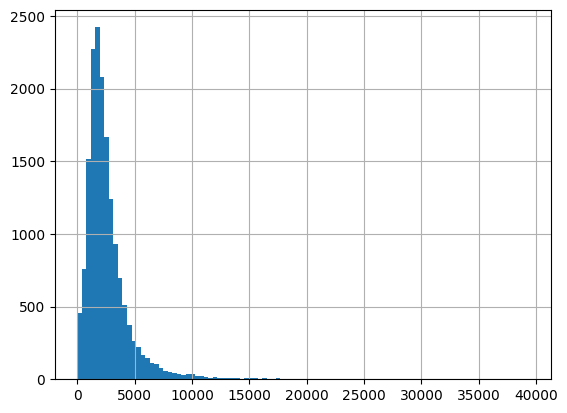

In [199]:
df['total_rooms'].hist(bins=100)

# Removing Outliers

In [200]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6


class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, attr_list=['total_rooms']): # no *args or **kargs
        self.attr_list = attr_list

    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X):
        for attr in self.attr_list:
            X = X[X[:, df.columns.get_loc(attr)] < np.percentile(X[:, df.columns.get_loc(attr)], 99)]
            return X

display(df.shape)
outlier_remover = OutlierRemover()
df_no_outliers = outlier_remover.transform(df.values)

print(len(df_no_outliers))

(16512, 9)

16346


In [201]:
df = load_housing_data()

display(df.shape)
attr_list = ['total_rooms']
for attr in attr_list:
    df = df.loc[df[attr] <= df[attr].quantile(0.99)].reset_index(drop=True)
display(df.shape)

df["income_cat"] = pd.cut(df["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["income_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

df = strat_train_set.drop("median_house_value", axis=1)
df_labels = strat_train_set["median_house_value"].copy()

(20640, 10)

(20433, 10)

Root Mean Squared Error: 67872.42924127776


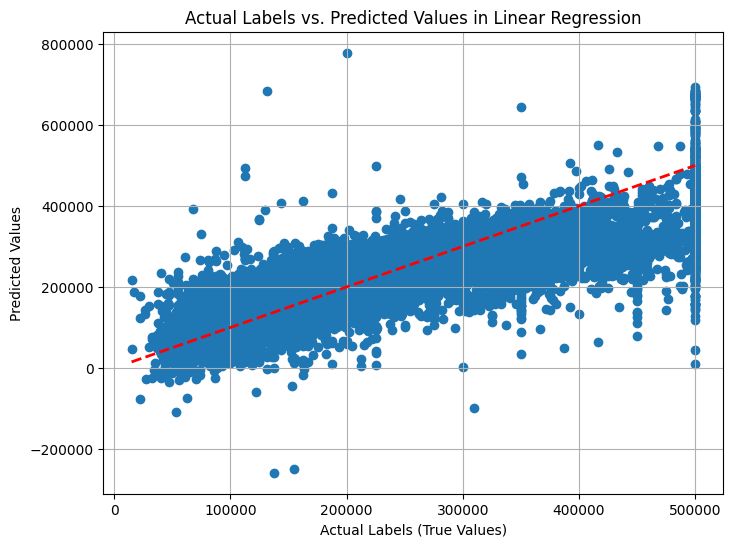

In [203]:
from sklearn.linear_model import LinearRegression

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
    # ('outlier_remover', OutlierRemover()), # Outlier removal should be done before scaling and in both training and test sets
])

num_attribs = list(df_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

df_prepared = full_pipeline.fit_transform(df)

lin_reg = LinearRegression()
lin_reg.fit(df_prepared, df_labels)

y_test = df_labels
y_pred = lin_reg.predict(df_prepared)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Root Mean Squared Error:", rmse)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=1) # Plot actual labels vs predicted values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Add a perfect prediction line (red dashed)
plt.xlabel("Actual Labels (True Values)")
plt.ylabel("Predicted Values")
plt.title("Actual Labels vs. Predicted Values in Linear Regression")
plt.grid(True)
plt.show()

In [215]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
15323,-117.26,33.09,13.0,3730.0,761.0,1335.0,603.0,4.1667,NEAR OCEAN
4363,-118.26,34.07,36.0,2306.0,813.0,2823.0,765.0,2.0214,<1H OCEAN
12317,-116.17,33.67,18.0,3585.0,800.0,3873.0,788.0,2.5714,INLAND
4530,-118.25,34.05,52.0,2806.0,1944.0,2232.0,1605.0,0.6775,<1H OCEAN
2361,-119.41,36.68,18.0,1802.0,332.0,945.0,292.0,3.4044,INLAND
...,...,...,...,...,...,...,...,...,...
12430,-121.48,38.56,50.0,1587.0,448.0,877.0,380.0,2.0833,INLAND
8730,-118.32,33.80,29.0,3254.0,717.0,1593.0,680.0,4.0536,<1H OCEAN
14709,-117.11,32.64,23.0,1619.0,447.0,1025.0,415.0,1.8580,NEAR OCEAN
19233,-121.06,37.67,31.0,906.0,146.0,383.0,129.0,3.4167,INLAND


In [216]:
df = load_housing_data()

display(df.shape)
attr_list = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
for attr in attr_list:
    df = df.loc[df[attr] <= df[attr].quantile(0.995)].reset_index(drop=True)
    df = df.loc[df[attr] >= df[attr].quantile(0.005)].reset_index(drop=True)
display(df.shape)

df["income_cat"] = pd.cut(df["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["income_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

df = strat_train_set.drop("median_house_value", axis=1)
df_labels = strat_train_set["median_house_value"].copy()

(20640, 10)

(19381, 10)

Root Mean Squared Error: 63431.089863228626


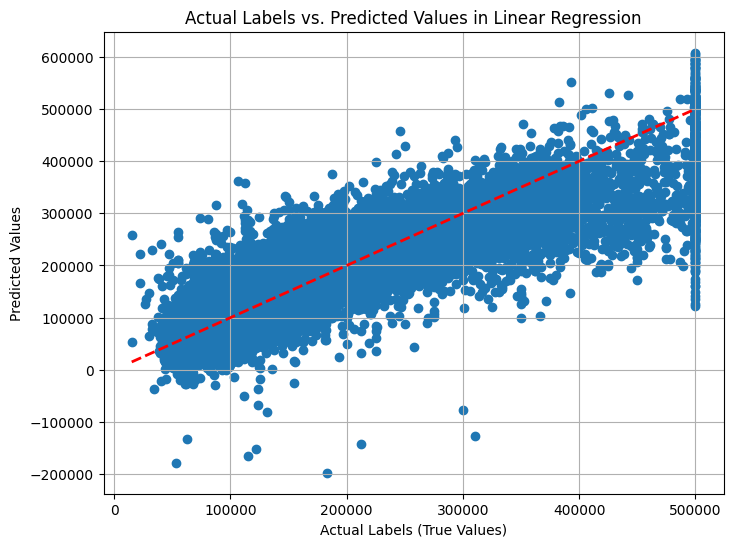

In [217]:
from sklearn.linear_model import LinearRegression

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
    # ('outlier_remover', OutlierRemover()), # Outlier removal should be done before scaling and in both training and test sets
])

num_attribs = list(df_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

df_prepared = full_pipeline.fit_transform(df)

lin_reg = LinearRegression()
lin_reg.fit(df_prepared, df_labels)

y_test = df_labels
y_pred = lin_reg.predict(df_prepared)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Root Mean Squared Error:", rmse)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=1) # Plot actual labels vs predicted values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Add a perfect prediction line (red dashed)
plt.xlabel("Actual Labels (True Values)")
plt.ylabel("Predicted Values")
plt.title("Actual Labels vs. Predicted Values in Linear Regression")
plt.grid(True)
plt.show()

[ 78308.00071032  51261.73786702 278366.98823275 ... 227350.84475195
 178070.09385441 102650.15236712]
Root Mean Squared Error: 62936.19165651444


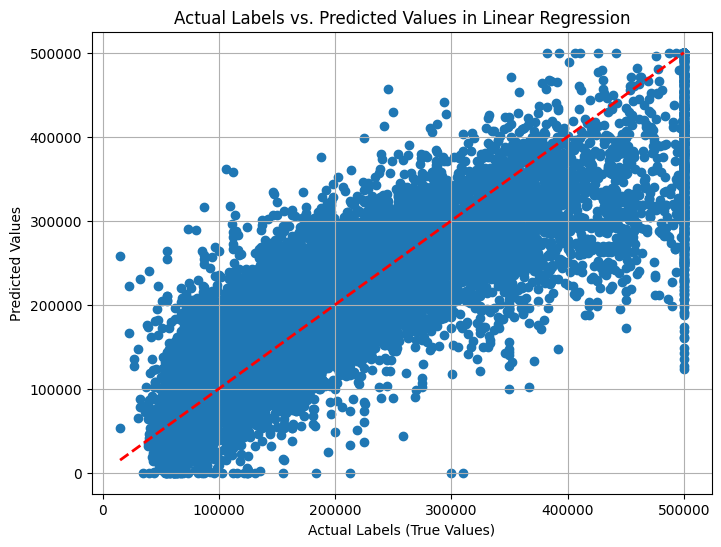

In [ ]:
from sklearn.linear_model import LinearRegression

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
    # ('outlier_remover', OutlierRemover()), # Outlier removal should be done before scaling and in both training and test sets
])

num_attribs = list(df_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

df_prepared = full_pipeline.fit_transform(df)

lin_reg = LinearRegression()
lin_reg.fit(df_prepared, df_labels)

y_test = df_labels
y_pred = lin_reg.predict(df_prepared)
y_pred = np.where(y_pred < 0, 0, y_pred)
y_pred = np.where(y_pred > 500000, 500000, y_pred)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Root Mean Squared Error:", rmse)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=1) # Plot actual labels vs predicted values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Add a perfect prediction line (red dashed)
plt.xlabel("Actual Labels (True Values)")
plt.ylabel("Predicted Values")
plt.title("Actual Labels vs. Predicted Values in Linear Regression")
plt.grid(True)
plt.show()

# Using Cross Validation

In [ ]:
df = load_housing_data()

df["income_cat"] = pd.cut(df["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

X = df.drop("median_house_value", axis=1)
y = df["median_house_value"].copy()

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["income_cat"]):
    X_train, y_train = df.loc[train_index]
    X_test, y_test = df.loc[test_index]

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)


display(df.shape)
attr_list = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
for attr in attr_list:
    df = df.loc[df[attr] <= df[attr].quantile(0.995)].reset_index(drop=True)
    df = df.loc[df[attr] >= df[attr].quantile(0.005)].reset_index(drop=True)
display(df.shape)

df["income_cat"] = pd.cut(df["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["income_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

df = strat_train_set.drop("median_house_value", axis=1)
df_labels = strat_train_set["median_house_value"].copy()